In [1]:
%pip install matplotlib numpy pandas pyarrow python-snappy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Acquire Data

In [2]:
import os
import zipfile
import urllib.request
import shutil
from pathlib import Path

url = "https://content.neuralink.com/compression-challenge/data.zip"

data_dir = Path("..") / "data"
if data_dir.exists():
    shutil.rmtree(data_dir)
    data_dir.mkdir()

# download the file
with urllib.request.urlopen(url) as response, open("data.zip", 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

# extract the zip file
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("..")

# remove the zip file
os.remove("data.zip")

In [3]:
file_paths = list(data_dir.iterdir())

file_paths[:3]

[PosixPath('../data/8dd8051b-94d0-4c73-9cf4-3447cbb0755d.wav'),
 PosixPath('../data/2a661247-dfa0-42b2-9d0a-a5925ac8735a.wav'),
 PosixPath('../data/e48befb9-a32a-4bcc-af7a-2cd62d76888c.wav')]

# File Analysis

In [4]:
import wave

file_path = file_paths[0]

with wave.open(str(file_path), 'rb') as f:
    num_channels = f.getnchannels()
    sample_rate = f.getframerate()
    sample_width = f.getsampwidth()
    num_frames = f.getnframes()
    duration = num_frames / sample_rate
    compression = f.getcomptype()

    print(f"num_channels: {num_channels}")
    print(f"sample_rate: {sample_rate}")
    print(f"sample_width: {sample_width}")
    print(f"num_frames: {num_frames}")
    print(f"duration: {duration}")
    print(f"compression: {compression}")


num_channels: 1
sample_rate: 19531
sample_width: 2
num_frames: 98634
duration: 5.050125441605653
compression: NONE


Single channel (mono), ~19.5 kHz sample rate, 2-byte samples. Assuming little-endian representation.

In [5]:
import wave

file_path = file_paths[0]

with wave.open(str(file_path), 'rb') as f:
    frames = f.readframes(3)
    for xi, xj in zip(frames[::2], frames[1::2]):
        y = int.from_bytes([xi, xj], byteorder='little', signed=True)
        print(y)


-3235
-4068
-3812


In [6]:
from typing import Collection
from pathlib import Path

def get_samples(path: Path) -> "Collection[int]":
    with wave.open(str(path), 'rb') as f:
        frames = f.readframes(f.getnframes())
        return [int.from_bytes([xi, xj], 'little', signed=True) for xi, xj in zip(frames[::2], frames[1::2])]
    
samples = get_samples(file_paths[0])

print(f"length: {len(samples)}")
print(f"min: {min(samples)}")
print(f"max: {max(samples)}")
print(f"ndv_ratio: {len(set(samples)) / len(samples)}")

length: 98634
min: -10474
max: 12587
ndv_ratio: 0.003507918162094207


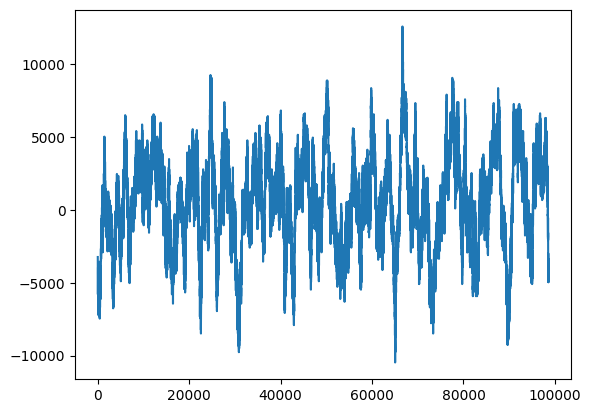

In [7]:
import matplotlib.pyplot as plt

get_samples(file_paths[0])

plt.plot(samples);

# Delta Encoding

In [8]:
from typing import Collection

def delta_encode(x: Collection[int]) -> Collection[int]:
    result = [x[0]]
    for i in range(1, len(x)):
        result.append(x[i] - x[i - 1])
    return result

def delta_decode(x: Collection[int]) -> Collection[int]:
    result = [x[0]]
    for i in range(1, len(x)):
        result.append(result[i - 1] + x[i])
    return result

# tests
delta_test = [1, 3, 6, 10, 15]
assert delta_encode(delta_test) == [1, 2, 3, 4, 5]
assert delta_decode(delta_encode(delta_test)) == delta_test

deltas = delta_encode(samples)

assert samples == delta_decode(deltas)

print(f"length: {len(deltas)}")
print(f"min: {min(deltas)}")
print(f"max: {max(deltas)}")
print(f"ndv_ratio: {len(set(deltas)) / len(deltas)}")

length: 98634
min: -3235
max: 5189
ndv_ratio: 0.0012470344911490966


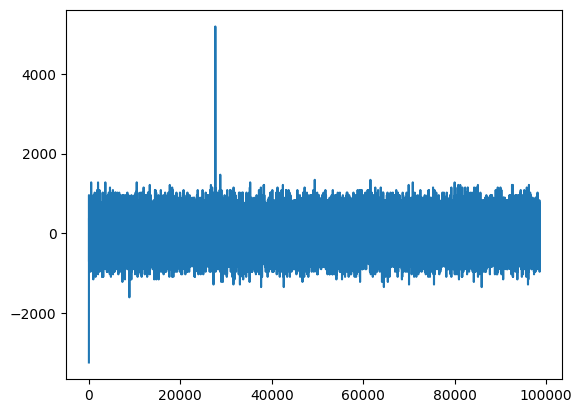

In [9]:
plt.plot(deltas);

In [10]:
ddeltas = delta_encode(deltas)

assert samples == delta_decode(delta_decode(ddeltas))

print(f"length: {len(ddeltas)}")
print(f"min: {min(ddeltas)}")

print(f"max: {max(ddeltas)}")
print(f"ndv_ratio: {len(set(ddeltas)) / len(ddeltas)}")

length: 98634
min: -4997
max: 5253
ndv_ratio: 0.0032747328507411236


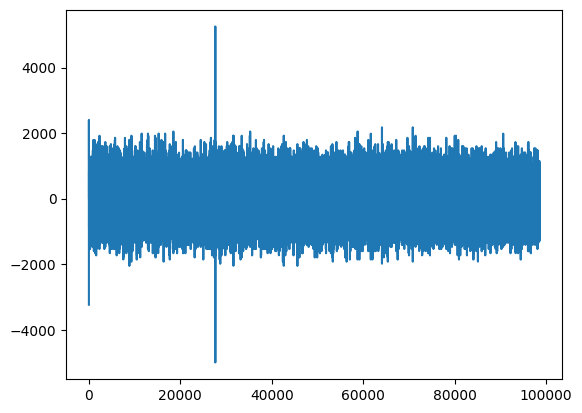

In [11]:
plt.plot(ddeltas);

Delta encoding produces smaller integer values than delta-delta encoding. 

# Dictionary Encoding

Due to "bounce" in data, delta-delta encoding (acceleration) is not as effective as delta encoding (velocity). The delta-encoded data has a very low NDV ratio, so dictionary encoding will be effective.

In [29]:
from typing import Collection, Tuple

def dict_encode(x: Collection[int]) -> Tuple[Collection[int], Collection[int]]:
    """
    returns tuple
        where first member is dictionary represented as list of unique values in x
        and second membder is x encoded using dictionary
    """
    d = dict()
    result = list()

    for xi in x:
        if xi not in d:
            d[xi] = len(d)
        result.append(d[xi])

    return list(d.keys()), result

def dict_decode(d: Collection[int], x: Collection[int]) -> Collection[int]:
    """
    returns x decoded using dictionary d
    """
    return [d[xi] for xi in x]

# tests
d, e = dict_encode(samples)
assert dict_decode(d, e) == samples

In [30]:
d, e = dict_encode(deltas)

print(f"length: {len(e)}")
print(f"min: {min(e)}")
print(f"max: {max(e)}")
print(f"ndv_ratio: {len(set(e)) / len(e)}")

print(d[:10])
print(e[100:110])

length: 98634
min: 0
max: 122
ndv_ratio: 0.0012470344911490966
[-3235, -833, 256, 321, -193, -192, 257, -128, -384, -64]
[2, 9, 24, 2, 9, 13, 23, 5, 35, 7]


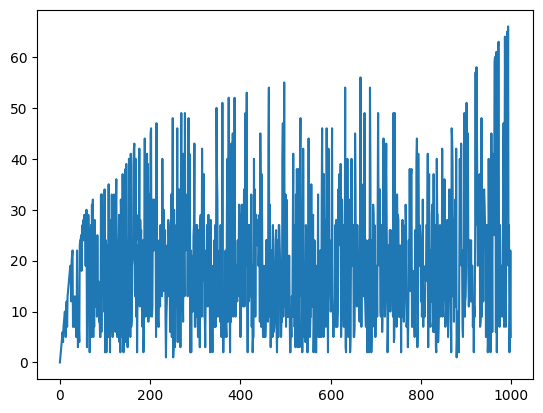

In [31]:
plt.plot(e[:1000]);

Dictionary-encoded deltas range from 0 to 122. Can be represented using 8-bit unsigned integer.

# Visualization

In [32]:
import pandas as pd

df = pd.DataFrame({"x": samples, "v": deltas, "e": e})

df.head()

,x,v,e
0,-3235,-3235,0
1,-4068,-833,1
2,-3812,256,2
3,-3491,321,3
4,-3684,-193,4


# Output Format

Output consists of the following layout:
- Encoded samples (Variable size 8-bit unsigned integer sequence)
- Dictionary (Variable size 16-bit signed integer sequence)
- Length (4-byte unsigned integer representing the number of samples in the encoded sequence)

In [76]:
from typing import Collection

def encode(x: Collection[int]) -> bytes:
    """
    encodes x using delta encoding and dictionary encoding
    output is bytes in the following format:
        - Encoded samples (8-bit unsigned integers)
        - Dictionary (16-bit unsigned integers)
        - 4-byte length of encoded samples
    """
    d, e = dict_encode(delta_encode(x))

    ebytes = b''.join([xi.to_bytes(1, 'little', signed=False) for xi in e])
    dbytes = b''.join([xi.to_bytes(2, 'little', signed=True) for xi in d])
    length = len(ebytes).to_bytes(4, 'little', signed=False)

    return ebytes + dbytes + length

def decode(x: bytes) -> Collection[int]:
    """
    decodes bytes encoded by encode function
    """
    l = int.from_bytes(x[-4:], 'little', signed=False)
    d = [int.from_bytes(x[i:i+2], 'little', signed=True) for i in range(l, len(x) - 4, 2)]
    e = [int.from_bytes(x[i:i+1], 'little', signed=False) for i in range(0, l)]

    return delta_decode(dict_decode(d, e))

encoded = encode(samples)

encoded[:100]

assert samples == decode(encoded)

e[0:10]

[0, 1, 2, 3, 4, 5, 6, 4, 7, 8]

# Compression

In [77]:
file_path = file_paths[0]

wav_size_bytes = file_path.stat().st_size
wav_size_kb = wav_size_bytes / 1024

print(f"wave_size: {wav_size_kb} KB")

wave_size: 192.6875 KB


In [78]:
import snappy

compressed = snappy.compress(encoded)

compressed_size_bytes = len(compressed)

compressed_size_kb = compressed_size_bytes / 1024

print(f"compressed_size: {compressed_size_kb} KB")

compressed_size: 96.57421875 KB


In [79]:
compression_ratio = compressed_size_bytes / wav_size_bytes

print(f"compression_ratio: {compression_ratio}")

compression_ratio: 0.5011960752513785
